# Positional Encoding for Transformers

Recurrent neural networks naturally encode the position of words in a sequence. Transformers, on the other hand, do not have an inbuilt mechanism to keep track of the order in which words appear. Therefore, positional information must be added to allow the model to learn how the order of words in a sequence affect the meaning of the sequence.

To begin, let's use the same sequence that we did for the word embedding:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

torch.manual_seed(1)
np.random.seed(42)

In [2]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

vocab = set(raw_text)
vocab_size = len(vocab)

word_to_ix = {word: i for i, word in enumerate(vocab)}
data = []

# Iterate through each target word, from the 3rd word to the N-3rd word in the sequence
for i in range(CONTEXT_SIZE, len(raw_text) - CONTEXT_SIZE):
    context = (
        [raw_text[i - j - 1] for j in range(CONTEXT_SIZE)] +    # Get the words behind the target
        [raw_text[i + j + 1] for j in range(CONTEXT_SIZE)]      # Get the words in front of the target
    )
    target = raw_text[i]                                        # Get the target
    data.append((context, target))

# Define the continuous bag of words class to create  the embeddings
class CBOW(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)           # Vocab size of
        self.linear1 = nn.Linear(context_size * embedding_dim * 2, 128)     # Input = 40 (context of 2 words * embedding size of 10 * 2 for words before and after -> 128 neurons
        self.linear2 = nn.Linear(128, vocab_size)                           # Input = 128 neurons -> 97 unique words
    
    def forward(self, inputs):
        embeds = self.embeddings(inputs).view(1, -1)                    # Squeezes the 10-length embeddings for the two words into a single 20-length tensor
        out = F.relu(self.linear1(embeds))                              # RelU activation function after the first neural network
        out = self.linear2(out)                                         # Runs the output of the first layer through the second layer
        log_probs = F.log_softmax(out, dim=1)                           # Returns the log probability for each word in the vocab using log softmax
        return log_probs

loss_function = nn.NLLLoss()
model = CBOW(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

def make_context_vector(context, word_to_ix):
    """Converts the input to a tensor with their corresponding indices in `word_to_ix`"""
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

losses = []
first_context = []
for epoch in range(50):
    total_loss = 0
    
    for context, target in data:
        
        # Step 1. Prepare the inputs to be passed to the model (i.e., turn the words 
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        if len(first_context) == 0:
            first_context.append(context_idxs[:3])
        
        # Step 2. Recall that torch accumulates gradients. Before passing in a new instance,
        # you need to zero out the gradients from the old instance
        model.zero_grad()
        
        # Step 3. Run the forward pass, getting the log probabilities over the next words
        log_probs = model(context_idxs)
        
        # Step 4. Compute your loss function (Again, Torch wants the target word wrapped
        # in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
        
        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()
        
        # Get the Python number from a 1-element tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
    
print(f"context_idxs = {first_context}")
print(f"Losses: {[round(i, 2) for i in losses[:5]]}...{[round(i, 2) for i in losses[-5:]]}")

context_idxs = [tensor([ 2, 13, 24])]
Losses: [227.88, 226.47, 225.07, 223.68, 222.3]...[168.78, 167.47, 166.16, 164.84, 163.53]


In [3]:

import pandas as pd
column_map = {i: f"Dim{i+1}" for i in range(EMBEDDING_DIM)}
word_embedding_df = pd.DataFrame()

print("Final word embeddings for:")
for i, word in enumerate(raw_text):
    word_embedding_df[word] = [i for i in model.embeddings.weight[word_to_ix[word]].detach().numpy()]

bag_of_words_df = word_embedding_df.T.rename(columns=column_map)

bag_of_words_df
    

Final word embeddings for:


,Dim1,Dim2,Dim3,Dim4,Dim5,Dim6,Dim7,Dim8,Dim9,Dim10
We,0.358527,1.198734,-0.303969,-1.760050,0.635311,-0.802808,-1.612228,-1.873384,0.545206,0.660903
are,0.873604,0.247107,-0.669292,0.816069,1.105435,-0.168423,-2.248190,-1.450568,0.062731,-0.610953
about,2.301765,0.673368,1.717240,-1.798046,-1.363106,-0.982295,1.511918,0.646229,0.468994,-0.431933
to,0.210388,0.948146,1.474470,-0.557466,-0.759216,-0.202405,-0.234235,-0.009261,0.376670,-0.588348
study,1.384807,-0.817520,-0.922184,1.113588,1.337684,0.601862,-0.108593,-0.147424,-2.105954,-0.620398
the,0.412991,-0.211821,-0.834640,-0.420401,-0.629887,-0.979148,0.880237,0.995225,0.309944,1.531905
idea,-1.594252,0.219156,1.292091,-0.819323,1.086391,0.182051,0.406410,1.608659,1.088210,0.733342
of,-0.397615,0.552227,-0.166073,-0.733538,0.792892,-0.346681,1.456756,0.296554,1.231554,-0.076444
a,0.054669,-0.436368,0.761604,0.445864,1.167264,2.044859,0.135243,0.966634,-0.201771,-0.645371
computational,-0.398827,-1.939258,0.223309,0.862208,0.616715,-1.780198,-0.783587,-1.425355,1.611093,-0.035063


To encode the position, we will need the position of the word and the dimensionality of the embeddings.

In [4]:
for i, word in enumerate(raw_text):
    print(f"Position: {i}\t|\tWord: {word} \t|\t{model.embeddings.weight[word_to_ix[word]].detach().numpy()[:3]}")

Position: 0	|	Word: We 	|	[ 0.35852748  1.1987343  -0.30396914]
Position: 1	|	Word: are 	|	[ 0.8736041  0.2471073 -0.6692916]
Position: 2	|	Word: about 	|	[2.301765   0.67336816 1.7172401 ]
Position: 3	|	Word: to 	|	[0.21038766 0.9481459  1.4744697 ]
Position: 4	|	Word: study 	|	[ 1.3848066 -0.8175205 -0.9221835]
Position: 5	|	Word: the 	|	[ 0.41299063 -0.21182139 -0.83464015]
Position: 6	|	Word: idea 	|	[-1.5942519   0.21915585  1.2920911 ]
Position: 7	|	Word: of 	|	[-0.3976152   0.5522266  -0.16607344]
Position: 8	|	Word: a 	|	[ 0.05466937 -0.4363683   0.76160437]
Position: 9	|	Word: computational 	|	[-0.3988275  -1.9392575   0.22330856]
Position: 10	|	Word: process. 	|	[-0.7747981 -0.2596847 -0.2320163]
Position: 11	|	Word: Computational 	|	[0.7263576  0.15170772 0.15074961]
Position: 12	|	Word: processes 	|	[ 0.39052078  0.3862279  -0.07116357]
Position: 13	|	Word: are 	|	[ 0.8736041  0.2471073 -0.6692916]
Position: 14	|	Word: abstract 	|	[ 2.4136474   1.0199648  -0.44527304]
Posit

We use two functions to embed unique information about each position into the embeddings.

$$
\begin{align*}
PE_{pos,2i} = sin(pos/10000^{2i/d_{model}}) \\
PE_{pos,2i+1} = cos(pos/10000^{2i/d_{model}})
\end{align*}
$$

The top equation maps embeddings to a sine function for words in even positions along the sequence, while the bottom function maps embeddings to a cosine function for words in odd positions along the sequence. Each position has a longer wavelength than the last, which makes each curve unique for each position. For a given word, each of its embeddings $i$ is mapped to the corresponding x-axis value in the positions sine or cosine function. The y-value of the curve at the embeddings x-value is the positional encoding. The positional encodings for each position are added to the input word embeddings.

Basically, each position has a unique sine or cosine function associated with it. For an embedding with 3 dimensions, the positional encoding would be a vector containing the y-values for an x of 1, 2, and 3. Since the wavelength increases at each position, this unique set of numbers that represents the position of the word in the sequence. The model can learn to determine which position a word is in by the values added to the input embeddings.

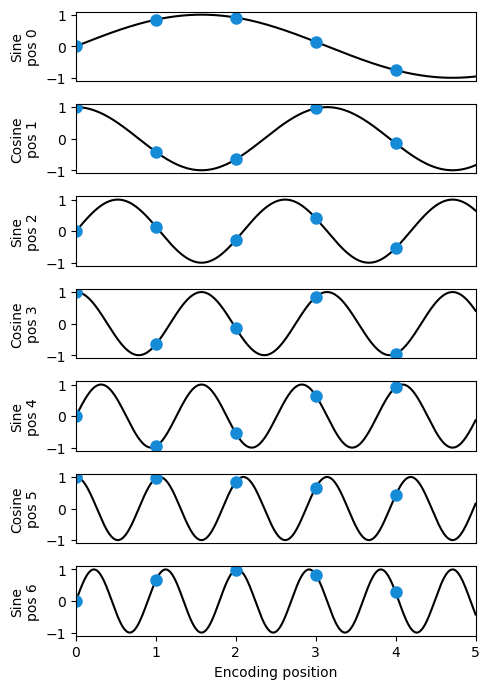

In [ ]:
import matplotlib.pyplot as plt



We can get the positional encodings using the formula in "Attention is all you need"

In [6]:
d_model = 10

def positional_encoding(pos: int, d_model: int) -> np.ndarray:
    i = np.arange(d_model)                         # [0..d_model-1]
    angles = pos / (10000 ** (2 * (i//2) / d_model))
    pe = np.empty(d_model, dtype=np.float64)
    pe[0::2] = np.sin(angles[0::2])               # even dims
    pe[1::2] = np.cos(angles[1::2])               # odd dims
    return pe

for pos, word in enumerate(raw_text[:3]):
    embeddings = model.embeddings.weight[word_to_ix[word]].detach().numpy()[:3]
    print(f"\nPosition: {pos} Word: {word}")
    pos_enc = positional_encoding(pos, d_model)
    print(f"  - Embeddings:   {embeddings}")
    print(f"  - Pos. Encode:  {pos_enc[:3]}")
    
    print(f"  - Embed + Pos:  {embeddings + pos_enc[:3]} ")


Position: 0 Word: We
  - Embeddings:   [ 0.35852748  1.1987343  -0.30396914]
  - Pos. Encode:  [0. 1. 0.]
  - Embed + Pos:  [ 0.35852748  2.19873428 -0.30396914] 

Position: 1 Word: are
  - Embeddings:   [ 0.8736041  0.2471073 -0.6692916]
  - Pos. Encode:  [0.84147098 0.54030231 0.15782664]
  - Embed + Pos:  [ 1.7150751   0.7874096  -0.51146498] 

Position: 2 Word: about
  - Embeddings:   [2.301765   0.67336816 1.7172401 ]
  - Pos. Encode:  [ 0.90929743 -0.41614684  0.31169715]
  - Embed + Pos:  [3.21106239 0.25722132 2.02893724] 


In [17]:
# create the positional encoding function using the formula above 

def getPositionEncoding(seq_len, d, n=10000): 

    # instantiate an array of 0s as a starting point 

    P = np.zeros((seq_len, d)) 

    # iterate through the positions of each word  

    for k in range(seq_len): 

        #calculate the positional encoding for even and odd position of each word 

        for i in np.arange(int(d/2)): 

            denominator = np.power(n, 2*i/d) 

            P[k, 2*i] = np.sin(k/denominator) 

            P[k, 2*i+1] = np.cos(k/denominator) 
    return P 



sequence = "Allen walked his dog down the street".split()
word_to_ix = [{i, x} for i, x in enumerate(sequence)]
embedding_dim = 6
P = getPositionEncoding(seq_len=len(sequence), d=embedding_dim, n=10000) 

position_embedding_df = pd.DataFrame(data=P, index=[i for i in sequence], columns =[f"Dim {i} (sin)" if i % 2 == 0 else f"Dim {i} (cos)" for i in np.arange(embedding_dim)])

position_embedding_df

,Dim 0 (sin),Dim 1 (cos),Dim 2 (sin),Dim 3 (cos),Dim 4 (sin),Dim 5 (cos)
Allen,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
walked,0.841471,0.540302,0.046399,0.998923,0.002154,0.999998
his,0.909297,-0.416147,0.092699,0.995694,0.004309,0.999991
dog,0.141120,-0.989992,0.138798,0.990321,0.006463,0.999979
down,-0.756802,-0.653644,0.184599,0.982814,0.008618,0.999963
the,-0.958924,0.283662,0.230002,0.973190,0.010772,0.999942
street,-0.279415,0.960170,0.274909,0.961470,0.012926,0.999916


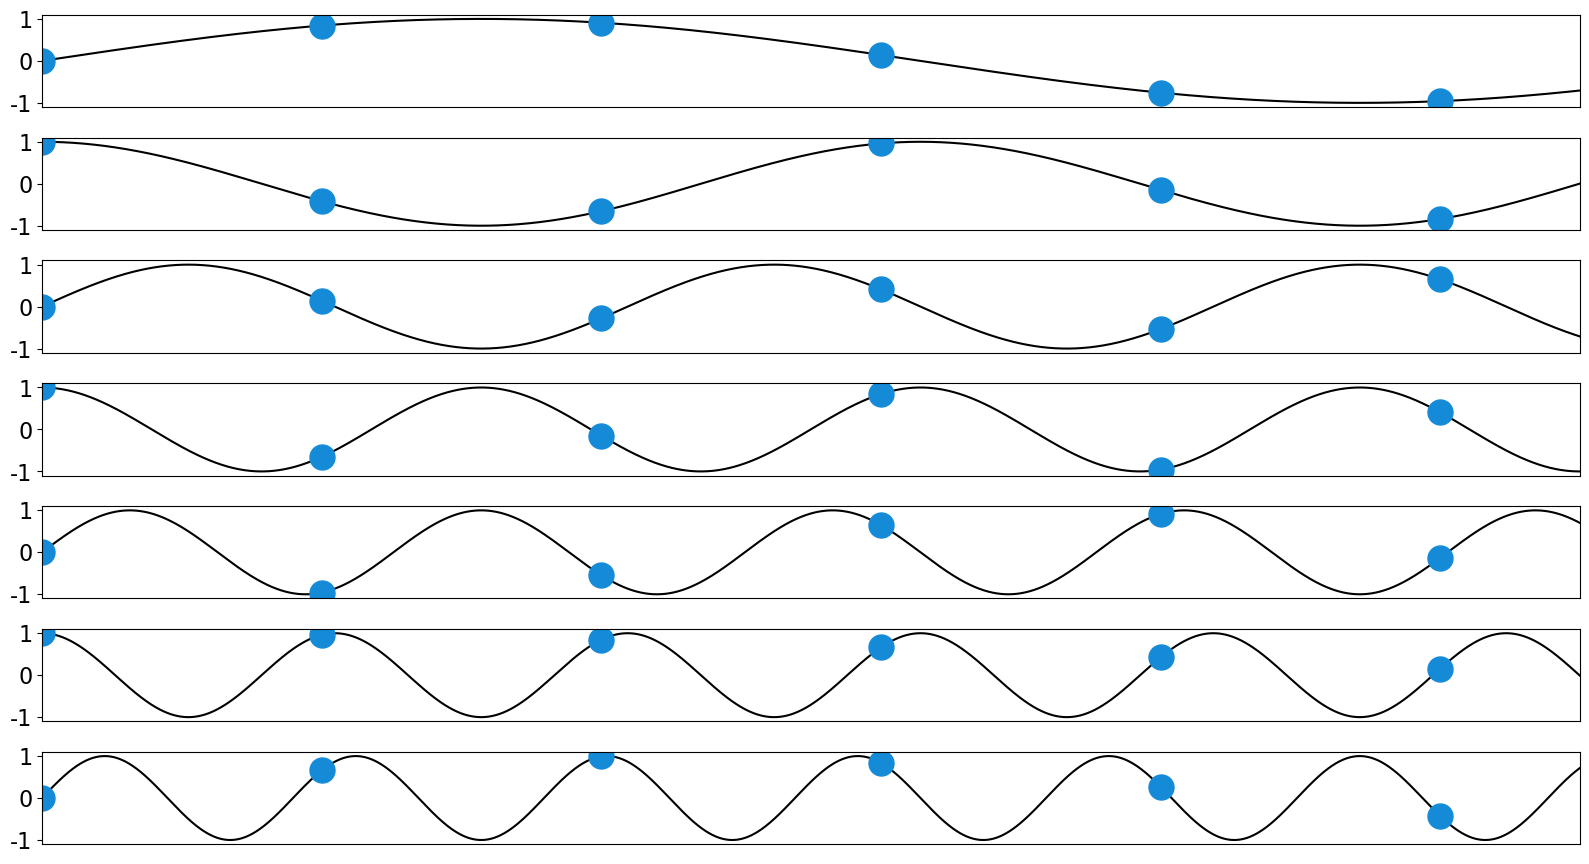

In [166]:
n_pos = len(sequence)
n_embeds = embedding_dim  # just a convenient x-range to show
fig, axes = plt.subplots(nrows=n_pos, ncols=1, figsize=(16, 1.25*n_pos), sharex=True)

if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

x = np.linspace(0, n_embeds, 10000)
dots = np.arange(0, n_embeds, 1)
for pos in range(0, n_pos):
    freq = pos + 1
    if pos % 2 == 0:
        # Plot the position-specific curve
        y = np.sin(freq * x)        
        
        axes[pos].plot(x, y, color="black")
        axes[pos].plot(dots, np.sin(freq * dots), 'o', color="#158bd8", markersize=18)
        
        # axes[pos].set_ylabel(sequence[pos], fontsize=18, rotation=0, labelpad=25)
        axes[pos].tick_params(axis='x', bottom=False)
        axes[pos].set_yticks([-1, 0, 1])
        axes[pos].set_xlim((0, 5.5))
        axes[pos].set_yticklabels(labels=[-1, 0, 1], fontsize=16, rotation=0)
        
    else:
        y = np.cos(freq * x)
        
        axes[pos].plot(x, y, color="black")
        axes[pos].plot(dots, np.cos(freq * dots), 'o', color="#158bd8", markersize=18)
        
        # axes[pos].set_ylabel(sequence[pos], fontsize=18, rotation=0, labelpad=25)
        
        axes[pos].tick_params(axis='x', bottom=False)
        axes[pos].set_yticks([-1, 0, 1])
        axes[pos].set_xlim((0, 5.5))
        axes[pos].set_yticklabels(labels=[-1, 0, 1], fontsize=16, rotation=0)
        
    
# axes[-1].set_xticklabels([f"Embedding {i}\n(sine)" if i % 2 == 0 else f"Embedding {i}\n(cosine)" for i in range(n_embeds)], fontsize=18, rotation=0)
# axes[-1].tick_params(axis='x', bottom=False, pad=10)
axes[-1].set_xticks([])

plt.tight_layout()
plt.show()

In [158]:
fig.savefig("position_embedding_curves.png", dpi=400)

In [84]:
import pandas as pd
import numpy as np

n_pos = len(sequence)
n_embeds = embedding_dim
dots = np.arange(0, n_embeds, 1)

# Collect values into a 2D array
values = []
for pos in range(n_pos):
    freq = pos + 1
    if pos % 2 == 0:
        row = np.sin(freq * dots).round(2)
    else:
        row = np.cos(freq * dots).round(2)
    values.append(row)

# Turn into DataFrame
dot_df = pd.DataFrame(
    data=values,
    index=[sequence[pos] for pos in range(n_pos)],
    columns=[f"Embedding {i} {'(sine)' if i % 2 == 0 else '(cosine)'}" for i in dots]
)

dot_df.to_csv("position_embedding_output.csv", sep=",", header=True, index=True)


/tmp/ipykernel_24718/2767849793.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

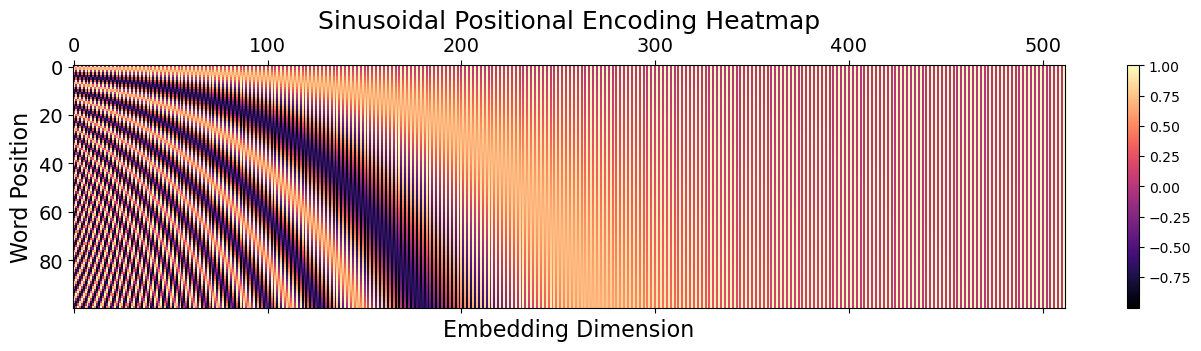

In [174]:
def get_position_encoding(seq_len, d_model, n=10000): 
    P = np.zeros((seq_len, d_model)) 
    for pos in range(seq_len): 
        for i in range(d_model): 
            angle = pos / np.power(n, (2 * (i // 2)) / d_model) 
            P[pos, i] = np.sin(angle) if i % 2 == 0 else np.cos(angle) 
    return P 

# Parameters 
seq_len = 100   # Number of tokens 
d_model = 512   # Embedding dimensions 

# Generate positional encoding 
P = get_position_encoding(seq_len, d_model) 
  
# Plot 
plt.figure(figsize=(10, 6)) 
cax = plt.matshow(P, cmap='magma', aspect='auto') 
plt.title("Sinusoidal Positional Encoding Heatmap", fontsize=18) 
plt.xlabel("Embedding Dimension", fontsize=16) 
plt.ylabel("Word Position", fontsize=16) 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.colorbar(cax) 
plt.tight_layout() 
plt.savefig("position_embedding_heatmap.png", dpi=400)

plt.show() 



In [184]:
from datetime import datetime

print(datetime.now().strftime("%d%m%y%H%M%S"))

190925170139
